Import libs

In [1]:
import os
import requests
import tarfile
import pandas as pd
from pandas.plotting import scatter_matrix
import numpy as np
import matplotlib.pyplot as plt
import joblib  # sklearn recommended model persistence library
from sklearn.impute import SimpleImputer
from sklearn.pipeline import Pipeline
from sklearn.compose import ColumnTransformer
from sklearn.preprocessing import OrdinalEncoder, OneHotEncoder, StandardScaler
from sklearn.model_selection import StratifiedShuffleSplit, train_test_split, cross_val_score, GridSearchCV
from sklearn.base import BaseEstimator, TransformerMixin
from sklearn.linear_model import LinearRegression
from sklearn.tree import DecisionTreeRegressor
from sklearn.metrics import mean_squared_error
from sklearn.ensemble import RandomForestRegressor
from scipy import stats
plt.style.use("dark_background")
%matplotlib inline

Download dataset (California Housing dataset)

In [2]:
def download_dataset():
    url = "https://raw.githubusercontent.com/ageron/handson-ml2/master/datasets/housing/housing.tgz"
    filename = url.split("/")[-1]

    # Download california housing price dataset
    if not os.path.isfile(filename):
        response = requests.get(url)
        with open(filename, "wb") as file:
            for chunk in response.iter_content(chunk_size=8 * 1024):
                file.write(chunk)

    # Extract california housing price dataset
    if os.path.isfile(filename) and not os.path.isfile("housing.csv"):
        with tarfile.open(filename) as file:
            file.extractall()
            print("Download and extracted")
download_dataset()

Read data from csv

In [3]:
housing = pd.read_csv("housing.csv")
housing.columns

Index(['longitude', 'latitude', 'housing_median_age', 'total_rooms',
       'total_bedrooms', 'population', 'households', 'median_income',
       'median_house_value', 'ocean_proximity'],
      dtype='object')

Analyze data, relationship, boundaries 

In [4]:
housing.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 20640 entries, 0 to 20639
Data columns (total 10 columns):
longitude             20640 non-null float64
latitude              20640 non-null float64
housing_median_age    20640 non-null float64
total_rooms           20640 non-null float64
total_bedrooms        20433 non-null float64
population            20640 non-null float64
households            20640 non-null float64
median_income         20640 non-null float64
median_house_value    20640 non-null float64
ocean_proximity       20640 non-null object
dtypes: float64(9), object(1)
memory usage: 1.6+ MB


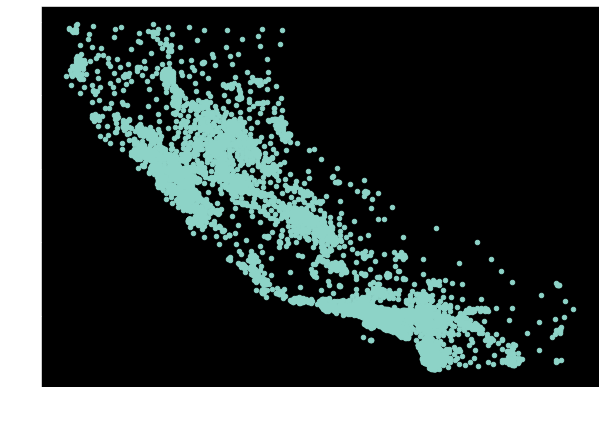

In [5]:
housing.plot(kind='scatter', x='longitude', y='latitude',
             figsize=(10, 7))
plt.show()

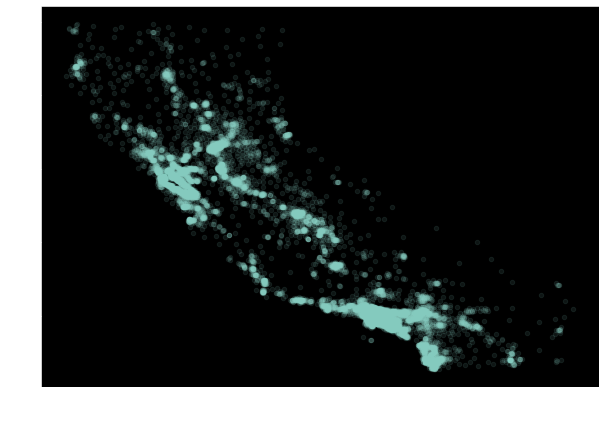

In [6]:
housing.plot(kind='scatter', x='longitude', y='latitude', alpha=0.1,
             figsize=(10, 7))
plt.show()

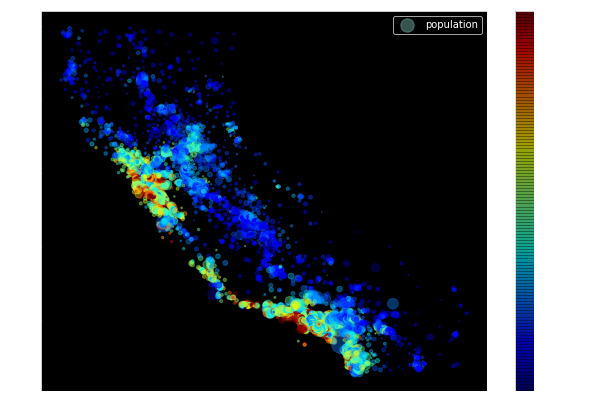

In [7]:
housing.plot(kind='scatter', x='longitude', y='latitude', alpha=0.4,
             s=housing['population']/100, label='population',
             figsize=(10, 7),
             c='median_house_value', cmap=plt.get_cmap('jet'),
             colorbar=True)
plt.legend()
plt.show()

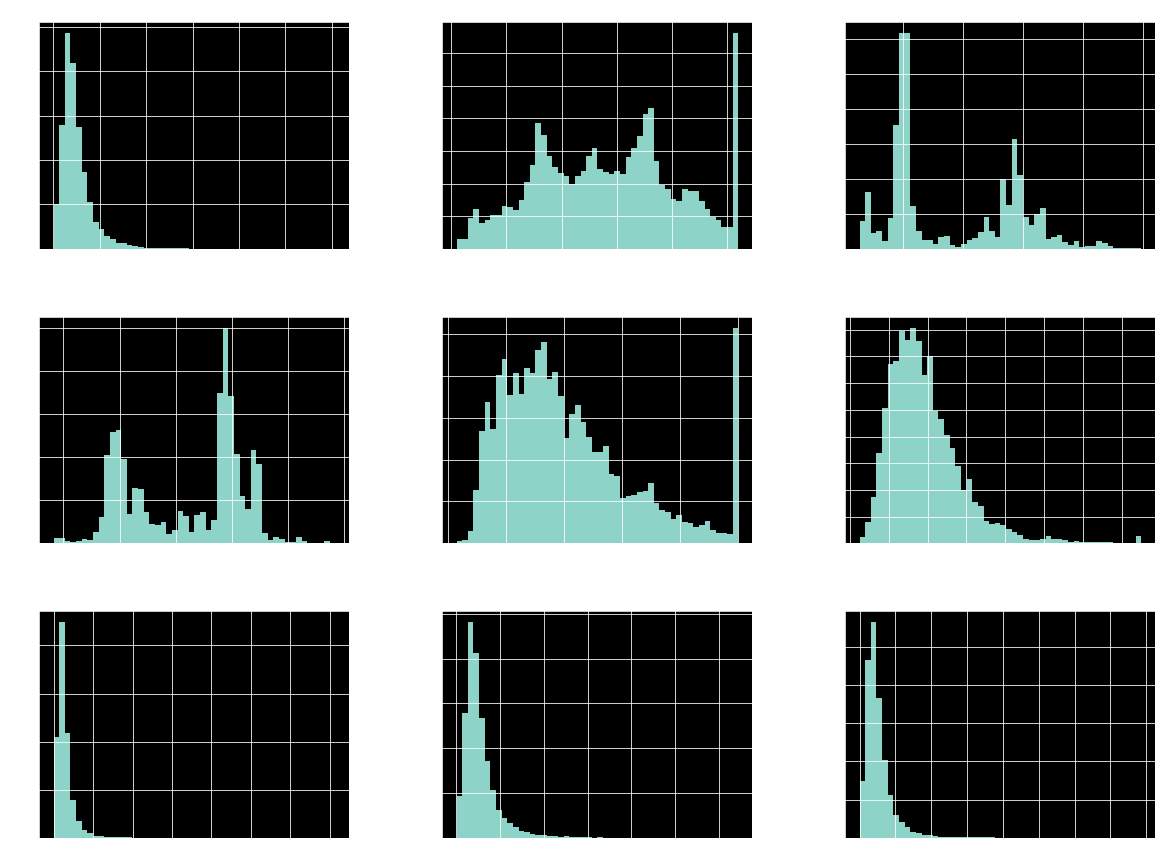

In [8]:
housing.hist(bins=50, figsize=(20, 15))
plt.show()

In [9]:
# housing['ocean_proximity'].unique()

In [10]:
# housing['ocean_proximity'].value_counts()

In [11]:
# mapping = {"ISLAND": 0, "NEAR BAY": 1, "NEAR OCEAN": 2, "<1H OCEAN": 3, "INLAND": 4}
# housing.replace(to_replace={"ocean_proximity": mapping}, inplace=True)
# housing['ocean_proximity'].unique()

In [12]:
# housing['ocean_proximity'].value_counts()

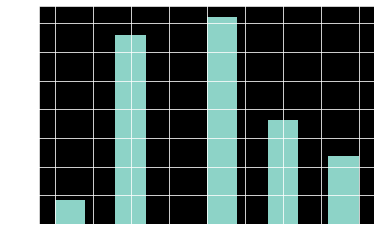

In [13]:
housing['income_cat'] = pd.cut(housing['median_income'],
                               bins=[0., 1.5, 3.0, 4.5, 6., np.inf],
                               labels=[1, 2, 3, 4, 5])
housing['income_cat'].hist()
plt.show()

Combine Attributes

In [14]:
housing['rooms_per_household'] = housing['total_rooms'] / housing['households']
housing['bedrooms_per_room'] = housing['total_bedrooms'] / housing['total_rooms']
housing['population_per_household'] = housing['population'] / housing['households']

In [15]:
corr_matrix = housing.corr()
corr_matrix['median_house_value'].sort_values(ascending=False)

median_house_value          1.000000
median_income               0.688075
rooms_per_household         0.151948
total_rooms                 0.134153
housing_median_age          0.105623
households                  0.065843
total_bedrooms              0.049686
population_per_household   -0.023737
population                 -0.024650
longitude                  -0.045967
latitude                   -0.144160
bedrooms_per_room          -0.255880
Name: median_house_value, dtype: float64

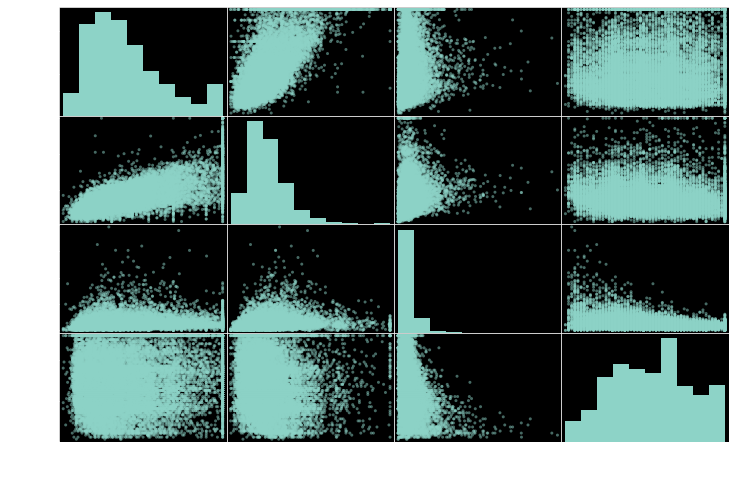

In [16]:
attributes = ['median_house_value', 'median_income', 'total_rooms', 'housing_median_age']
scatter_matrix(housing[attributes], figsize=(12, 8))
plt.show()

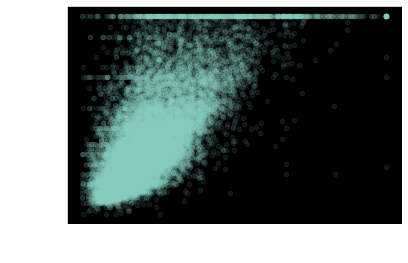

In [17]:
housing.plot(kind='scatter', x='median_income', y='median_house_value', alpha=0.1)
plt.show()

Data Cleaning

option 1

In [18]:
# housing.dropna(subset=['total_bedrooms'], inplace=True)

option 2

In [19]:
# housing.drop('total_bedrooms', axis=1, inplace=True)

option 3

Remember, if we already split dataset into train_set and test_set, we only need to
calculate median value based on train_set, save this median value and also apply
this median value on test set.

In [20]:
# median = housing['total_bedrooms'].median()
# housing['total_bedrooms'].fillna(median, inplace=True)

option 4 (sklearn SimpleImputer)

We need to train this Imputer to fill all missing data from our dataset,
remember to save this imputer for pre-processing incoming data when the system goes live.

This imputer calculate all column's median value and save the results in its
statistics_ variable.

For the dataset we read from housing.csv, only total_bedrooms has missing data but we
cannot guarentee that there won't be any missing values in new data after system goes live,
so it is safer to apply the imputer to all the numberical attributes

In [21]:
# from sklearn.impute import SimpleImputer
imputer = SimpleImputer(strategy='median')
housing_num = housing.drop('ocean_proximity', axis=1)
imputer.fit(housing_num)

joblib.dump(imputer, 'housing.imputer')
imputer = joblib.load('housing.imputer')

In [22]:
imputer.statistics_

array([-1.18490000e+02,  3.42600000e+01,  2.90000000e+01,  2.12700000e+03,
        4.35000000e+02,  1.16600000e+03,  4.09000000e+02,  3.53480000e+00,
        1.79700000e+05,  3.00000000e+00,  5.22912879e+00,  2.03162434e-01,
        2.81811565e+00])

In [23]:
housing_num.median().values

array([-1.18490000e+02,  3.42600000e+01,  2.90000000e+01,  2.12700000e+03,
        4.35000000e+02,  1.16600000e+03,  4.09000000e+02,  3.53480000e+00,
        1.79700000e+05,  3.00000000e+00,  5.22912879e+00,  2.03162434e-01,
        2.81811565e+00])

In [24]:
# Fill all na valus in housing_num
temp_X = imputer.transform(housing_num)
housing_tr = pd.DataFrame(temp_X, columns=housing_num.columns, index=housing_num.index)
housing_tr.head(10)

,longitude,latitude,housing_median_age,total_rooms,total_bedrooms,population,households,median_income,median_house_value,income_cat,rooms_per_household,bedrooms_per_room,population_per_household
0,-122.23,37.88,41.0,880.0,129.0,322.0,126.0,8.3252,452600.0,5.0,6.984127,0.146591,2.555556
1,-122.22,37.86,21.0,7099.0,1106.0,2401.0,1138.0,8.3014,358500.0,5.0,6.238137,0.155797,2.109842
2,-122.24,37.85,52.0,1467.0,190.0,496.0,177.0,7.2574,352100.0,5.0,8.288136,0.129516,2.802260
3,-122.25,37.85,52.0,1274.0,235.0,558.0,219.0,5.6431,341300.0,4.0,5.817352,0.184458,2.547945
4,-122.25,37.85,52.0,1627.0,280.0,565.0,259.0,3.8462,342200.0,3.0,6.281853,0.172096,2.181467
5,-122.25,37.85,52.0,919.0,213.0,413.0,193.0,4.0368,269700.0,3.0,4.761658,0.231774,2.139896
6,-122.25,37.84,52.0,2535.0,489.0,1094.0,514.0,3.6591,299200.0,3.0,4.931907,0.192899,2.128405
7,-122.25,37.84,52.0,3104.0,687.0,1157.0,647.0,3.1200,241400.0,3.0,4.797527,0.221327,1.788253
8,-122.26,37.84,42.0,2555.0,665.0,1206.0,595.0,2.0804,226700.0,2.0,4.294118,0.260274,2.026891
9,-122.25,37.84,52.0,3549.0,707.0,1551.0,714.0,3.6912,261100.0,3.0,4.970588,0.199211,2.172269


Split dataset into train_set and test_set

In [25]:
housing_cat = housing[["ocean_proximity"]]
housing_cat.head(10)

,ocean_proximity
0,NEAR BAY
1,NEAR BAY
2,NEAR BAY
3,NEAR BAY
4,NEAR BAY
5,NEAR BAY
6,NEAR BAY
7,NEAR BAY
8,NEAR BAY
9,NEAR BAY


In [26]:
ordinal_encoder = OrdinalEncoder()
housing_cat_encoded = ordinal_encoder.fit_transform(housing_cat)
housing_cat_encoded[:10]

array([[3.],
       [3.],
       [3.],
       [3.],
       [3.],
       [3.],
       [3.],
       [3.],
       [3.],
       [3.]])

In [27]:
ordinal_encoder.categories_

[array(['<1H OCEAN', 'INLAND', 'ISLAND', 'NEAR BAY', 'NEAR OCEAN'],
       dtype=object)]

In [28]:
onehot_encoder = OneHotEncoder()
housing_cat_1hot = onehot_encoder.fit_transform(housing_cat)
housing_cat_1hot.toarray()[:10]

array([[0., 0., 0., 1., 0.],
       [0., 0., 0., 1., 0.],
       [0., 0., 0., 1., 0.],
       [0., 0., 0., 1., 0.],
       [0., 0., 0., 1., 0.],
       [0., 0., 0., 1., 0.],
       [0., 0., 0., 1., 0.],
       [0., 0., 0., 1., 0.],
       [0., 0., 0., 1., 0.],
       [0., 0., 0., 1., 0.]])

Example of Custom Transformers

In [29]:
rooms_ix, bedrooms_ix, population_ix, households_ix = 3, 4, 5, 6

class CombinedAttributesAdder(BaseEstimator, TransformerMixin):
    def __init__(self, add_bedrooms_per_room = True):  # no *args or **kwargs
        self.add_bedrooms_per_room = add_bedrooms_per_room
    def fit(self, X, y=None):
        return self
    def transform(self, X, y=None):
        rooms_per_bedroom = X[:, rooms_ix] / X[:, households_ix]
        population_per_household = X[:, population_ix] / X[:, households_ix]
        if self.add_bedrooms_per_room:
            bedrooms_per_room = X[:, bedrooms_ix] / X[:, households_ix]
            return np.c_[X, rooms_per_bedroom, population_per_household, bedrooms_per_room]
        else:
            return np.c_[X, rooms_per_bedroom, population_per_household]
        
attr_adder = CombinedAttributesAdder(add_bedrooms_per_room=False)
housing_extra_attributes = attr_adder.transform(housing.values)
housing_extra_attributes

array([[-122.23, 37.88, 41.0, ..., 2.5555555555555554, 6.984126984126984,
        2.5555555555555554],
       [-122.22, 37.86, 21.0, ..., 2.109841827768014, 6.238137082601054,
        2.109841827768014],
       [-122.24, 37.85, 52.0, ..., 2.8022598870056497, 8.288135593220339,
        2.8022598870056497],
       ...,
       [-121.22, 39.43, 17.0, ..., 2.325635103926097, 5.20554272517321,
        2.325635103926097],
       [-121.32, 39.43, 18.0, ..., 2.1232091690544412, 5.329512893982808,
        2.1232091690544412],
       [-121.24, 39.37, 16.0, ..., 2.616981132075472, 5.254716981132075,
        2.616981132075472]], dtype=object)

In [30]:
num_pipeline = Pipeline([
    ('imputer', SimpleImputer(strategy="median")),
    ('attribs_adder', CombinedAttributesAdder()),
    ('std_scalar', StandardScaler())
])

housing_num_tr = num_pipeline.fit_transform(housing_num)

num_attribs = list(housing_num)
cat_attribs = ["ocean_proximity"]

full_pipeline = ColumnTransformer([
    ('num', num_pipeline, num_attribs),
    ('cat', OneHotEncoder(), cat_attribs)
])

housing_prepared = full_pipeline.fit_transform(housing)

In [31]:
# Locate the target
median_house_value_index = list(housing.columns).index('median_house_value')

Split Train set and Test set

In [32]:
X = np.delete(housing_prepared, median_house_value_index, axis=1)
y = housing_prepared[:, median_house_value_index]
X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.2, random_state=42)


In [33]:
X_train[0]

array([ 1.26764451, -1.36797628,  0.34647803,  0.22471827,  0.21498587,
        0.7722505 ,  0.32292363, -0.32165429, -0.00633994, -0.16625886,
       -0.21428694,  0.05980847, -0.16625886,  0.05980847, -0.18200958,
        0.        ,  0.        ,  0.        ,  0.        ,  1.        ])

Linear Regression Model

In [34]:
lin_reg = LinearRegression()
lin_reg.fit(X_train, y_train)

LinearRegression(copy_X=True, fit_intercept=True, n_jobs=None, normalize=False)

Decision Tree Regressor Model

In [35]:
tree_reg = DecisionTreeRegressor()
tree_reg.fit(X_train, y_train)

DecisionTreeRegressor(ccp_alpha=0.0, criterion='mse', max_depth=None,
                      max_features=None, max_leaf_nodes=None,
                      min_impurity_decrease=0.0, min_impurity_split=None,
                      min_samples_leaf=1, min_samples_split=2,
                      min_weight_fraction_leaf=0.0, presort='deprecated',
                      random_state=None, splitter='best')

Random Forest Regressor Model

In [36]:
forest_reg = RandomForestRegressor()
forest_reg.fit(X_train, y_train)

RandomForestRegressor(bootstrap=True, ccp_alpha=0.0, criterion='mse',
                      max_depth=None, max_features='auto', max_leaf_nodes=None,
                      max_samples=None, min_impurity_decrease=0.0,
                      min_impurity_split=None, min_samples_leaf=1,
                      min_samples_split=2, min_weight_fraction_leaf=0.0,
                      n_estimators=100, n_jobs=None, oob_score=False,
                      random_state=None, verbose=0, warm_start=False)

# Evaluate the model
Calculate LinearRegression Model's Root Mean Squared Error

### Calculate Root Mean Squared Error

LinearRegression Model

DecisionTreeRegressor Model

RandomForestRegressor Model


In [37]:
lin_predicts = lin_reg.predict(X_test[:10])
print("Predictions:", lin_predicts)
print("Acutal     :", y_test[:10])

tree_predicts = tree_reg.predict(X_test[:10])
print("Predictions:", tree_predicts)
print("Acutal     :", y_test[:10])

forest_predicts = forest_reg.predict(X_test[:10])
print("Predictions:", forest_predicts)
print("Acutal     :", y_test[:10])

Predictions: [-1.51254456 -0.62899816  0.76795168  0.68561836  0.5004743  -0.10296833
  0.5353558  -0.07724037  0.51506735  1.81499058]
Acutal     : [-1.37925233 -1.39571783  2.54041094  0.10177568  0.61653908 -0.41732074
 -0.07501175 -0.42772     1.1538342   2.07763518]
Predictions: [-1.37665252 -1.16866731  2.54041094  0.24649872  0.05064599 -0.54471168
  2.54041094 -0.28473017  0.50821345  2.54041094]
Acutal     : [-1.37925233 -1.39571783  2.54041094  0.10177568  0.61653908 -0.41732074
 -0.07501175 -0.42772     1.1538342   2.07763518]
Predictions: [-1.32462155 -1.12080463  1.98249396  0.43313079  0.19159063 -0.41860331
  0.50410669  0.06587276  0.45150316  2.38064987]
Acutal     : [-1.37925233 -1.39571783  2.54041094  0.10177568  0.61653908 -0.41732074
 -0.07501175 -0.42772     1.1538342   2.07763518]


In [38]:
lin_housing_predictions = lin_reg.predict(X_test)
lin_mse = mean_squared_error(y_test, lin_housing_predictions)
lin_rmse = np.sqrt(lin_mse)
print("Lin RMSE   :", lin_rmse)

tree_housing_predictions = tree_reg.predict(X_test)
tree_mse = mean_squared_error(y_test, tree_housing_predictions)
tree_rmse = np.sqrt(tree_mse)
print("Tree RMSE  :", tree_rmse)

forest_housing_predictions = forest_reg.predict(X_test)
forest_mse = mean_squared_error(y_test, forest_housing_predictions)
forest_rmse = np.sqrt(forest_mse)
print("Forest RMSE:", forest_rmse)

Lin RMSE   : 0.5967278370097505
Tree RMSE  : 0.6240076231021252
Forest RMSE: 0.4319860664853776


# Better Evaluation Using Cross-Validation

In [39]:
def display_scores(scores):
    print("Scores             :", scores)
    print("Mean               :", scores.mean())
    print("Standard deviation :", scores.std())

In [40]:
lin_scores = cross_val_score(lin_reg, X_test, y_test, scoring="neg_mean_squared_error", cv=10)
lin_rmse_scores = np.sqrt(-lin_scores)
display_scores(lin_rmse_scores)

tree_scores = cross_val_score(tree_reg, X_test, y_test, scoring="neg_mean_squared_error", cv=10)
tree_rmse_scores = np.sqrt(-tree_scores)
display_scores(tree_rmse_scores)

forest_scores = cross_val_score(forest_reg, X_test, y_test, scoring="neg_mean_squared_error", cv=10)
forest_rmse_scores = np.sqrt(-forest_scores)
display_scores(forest_rmse_scores)

Scores             : [0.73525116 0.59446687 0.65124145 0.62518885 0.62212348 0.55513046
 0.58755203 0.64107535 0.59256719 0.6107047 ]
Mean               : 0.6215301554477305
Standard deviation : 0.04632804449583543
Scores             : [0.70156055 0.68832827 0.6715872  0.70311704 0.68943431 0.62380722
 0.70069866 0.65417007 0.65458719 0.68377734]
Mean               : 0.6771067859462296
Standard deviation : 0.02461303872503965
Scores             : [0.4736176  0.45303175 0.50486589 0.54594889 0.48159116 0.4517814
 0.45536846 0.51084391 0.49432207 0.46717552]
Mean               : 0.4838546647620019
Standard deviation : 0.02883309865792297


# Grid Search

In [41]:
param_grid = [
    {'n_estimators': [3, 10, 30], 'max_features': [2, 4, 6, 8]},
    {'bootstrap': [False], 'n_estimators': [3, 10], 'max_features': [2, 3, 4]}
]

forest_reg = RandomForestRegressor()
grid_search = GridSearchCV(forest_reg, param_grid, cv=5, scoring='neg_mean_squared_error', return_train_score=True)

grid_search.fit(X_train, y_train)

GridSearchCV(cv=5, error_score=nan,
             estimator=RandomForestRegressor(bootstrap=True, ccp_alpha=0.0,
                                             criterion='mse', max_depth=None,
                                             max_features='auto',
                                             max_leaf_nodes=None,
                                             max_samples=None,
                                             min_impurity_decrease=0.0,
                                             min_impurity_split=None,
                                             min_samples_leaf=1,
                                             min_samples_split=2,
                                             min_weight_fraction_leaf=0.0,
                                             n_estimators=100, n_jobs=None,
                                             oob_score=False, random_state=None,
                                             verbose=0, warm_start=False),
             iid='deprecated', n_jo

In [42]:
grid_search.best_params_

{'max_features': 8, 'n_estimators': 30}

In [43]:
grid_search.best_estimator_

RandomForestRegressor(bootstrap=True, ccp_alpha=0.0, criterion='mse',
                      max_depth=None, max_features=8, max_leaf_nodes=None,
                      max_samples=None, min_impurity_decrease=0.0,
                      min_impurity_split=None, min_samples_leaf=1,
                      min_samples_split=2, min_weight_fraction_leaf=0.0,
                      n_estimators=30, n_jobs=None, oob_score=False,
                      random_state=None, verbose=0, warm_start=False)

In [44]:
cvres = grid_search.cv_results_
for mean_score, params in zip(cvres["mean_test_score"], cvres["params"]):
    print(np.sqrt(-mean_score), params)

0.5724411434390135 {'max_features': 2, 'n_estimators': 3}
0.498627047556214 {'max_features': 2, 'n_estimators': 10}
0.46923914148954277 {'max_features': 2, 'n_estimators': 30}
0.5349665211520654 {'max_features': 4, 'n_estimators': 3}
0.47462653984705433 {'max_features': 4, 'n_estimators': 10}
0.4537741616321943 {'max_features': 4, 'n_estimators': 30}
0.5322371211182895 {'max_features': 6, 'n_estimators': 3}
0.4679519195966018 {'max_features': 6, 'n_estimators': 10}
0.44985129185758604 {'max_features': 6, 'n_estimators': 30}
0.5249784969266591 {'max_features': 8, 'n_estimators': 3}
0.4613631345846562 {'max_features': 8, 'n_estimators': 10}
0.44658274736890446 {'max_features': 8, 'n_estimators': 30}
0.5534187077114032 {'bootstrap': False, 'max_features': 2, 'n_estimators': 3}
0.47900285886986943 {'bootstrap': False, 'max_features': 2, 'n_estimators': 10}
0.5420500093272286 {'bootstrap': False, 'max_features': 3, 'n_estimators': 3}
0.4715167869188433 {'bootstrap': False, 'max_features': 3

In [45]:
feature_importances = grid_search.best_estimator_.feature_importances_
feature_importances

array([5.50668613e-02, 5.06659262e-02, 4.09094627e-02, 1.27978125e-02,
       1.24354128e-02, 1.29112979e-02, 1.18996042e-02, 2.54694904e-01,
       1.56028143e-01, 2.18064023e-02, 5.35324203e-02, 6.57907022e-02,
       2.19176867e-02, 6.02047671e-02, 1.90523799e-02, 9.21837344e-03,
       1.33366920e-01, 2.34477671e-04, 3.56567207e-03, 3.90077322e-03])

In [46]:
extra_attribs = ["rooms_per_hhold", "pop_per_hhold", "bedrooms_per_hhold"]
cat_encoder = full_pipeline.named_transformers_["cat"]
cat_one_hot_attribs = list(cat_encoder.categories_[0])
attributes = num_attribs + cat_one_hot_attribs

sorted(zip(feature_importances, attributes), reverse=True)

[(0.25469490388501037, 'median_income'),
 (0.15602814336097104, 'median_house_value'),
 (0.13336692022533586, 'NEAR BAY'),
 (0.06579070224871689, 'bedrooms_per_room'),
 (0.06020476706708322, '<1H OCEAN'),
 (0.05506686127884744, 'longitude'),
 (0.05353242032277497, 'rooms_per_household'),
 (0.05066592622173529, 'latitude'),
 (0.040909462728101975, 'housing_median_age'),
 (0.021917686749136026, 'population_per_household'),
 (0.021806402264172835, 'income_cat'),
 (0.019052379916284015, 'INLAND'),
 (0.01291129786487413, 'population'),
 (0.012797812541191597, 'total_rooms'),
 (0.012435412762910722, 'total_bedrooms'),
 (0.011899604164391345, 'households'),
 (0.009218373439594644, 'ISLAND'),
 (0.00023447767126044466, 'NEAR OCEAN')]

In [47]:
final_model = grid_search.best_estimator_
final_predictions = final_model.predict(X_test)
final_mse = mean_squared_error(y_test, final_predictions)
final_rmse = np.sqrt(final_mse)
print(final_rmse)

0.4412068891091802


In [48]:
confidence = 0.95
squared_errors = (final_predictions - y_test) ** 2
np.sqrt(stats.t.interval(confidence, len(squared_errors) - 1, loc=squared_errors.mean(), scale=stats.sem(squared_errors)))

array([0.42117424, 0.46036865])